# Error Plot for JCPexample6

## Steady Flow Past Disk

### Import Stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
#import scipy.special as bessel
#from scipy.io import loadmat

import DRLPDE_nn
import DRLPDE_param_solver
import DRLPDE_functions.DefineDomain
import DRLPDE_functions.EvaluateWalkers

import matplotlib.pyplot as plt
#import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300
#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = ['Computer Modern']
#plt.rcParams['font.size'] = 12

In [2]:
### Domain Parameters

velocity_vtk = 'Steady_FPD_u_1-513787'
pressure_vtk = 'Steady_FPD_p_1-513787'

### Domain Parameters
dim = 2

L_right = 2.5
L_left = 0
L_height = L_right/5
R = L_height/3

circle_centre = [L_height,0]

######################## Plotting and Error Parameters ########################
numpts_x = 257
numpts_y =  129

x1g, x2g = torch.meshgrid([torch.linspace(L_left,L_right,numpts_x),
                              torch.linspace(-L_height,L_height,numpts_y)])

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1)], dim=-1).requires_grad_(True)

integral_factor = ((L_right - L_left)/(numpts_x-1))*((2*L_height)/(numpts_y-1))

x1plot = x1g.detach().cpu().numpy()
x2plot = x2g.detach().cpu().numpy()

/home/mskpark/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
### Load the IBM model
Nx = 256 # Number of points along x-axis - Does not count end point
Ny = 160 # Number of points along y-axis - Does not count end point
N_channel = 128
num_files = 100

data_vel = np.loadtxt('tools/vtk_files/' + velocity_vtk + '.vtk').reshape((Nx*Ny,3))

IBM_U = np.transpose( data_vel[:,0].reshape(Ny,Nx) )
IBM_V = np.transpose( data_vel[:,1].reshape(Ny,Nx) )
IBM_P = np.transpose( np.loadtxt('tools/vtk_files/' + pressure_vtk + '.vtk') )

### Restrict to values in the pipe
IBM_U = IBM_U[:, 16:N_channel + 16 + 1]
IBM_V = IBM_V[:, 16:N_channel + 16 + 1]
IBM_P = IBM_P[:, 16:N_channel + 16 + 1]

IBM_U = np.concatenate( (IBM_U, IBM_U[0,None,:]), axis=0)
IBM_V = np.concatenate( (IBM_V, IBM_V[0,None,:]), axis=0)
IBM_P = np.concatenate( (IBM_P, IBM_P[0,None,:]), axis=0)

In [4]:
### Load Trained model
nn_param = {'depth': 60,
                'width': 4,
                'x_dim':2,
                'is_unsteady':False ,
                'output_dim':2
                }

loadmodel = 'JCPexample6_continuation'

Velocity_NN = DRLPDE_nn.IncompressibleNN
model_vel = Velocity_NN(**nn_param)
model_vel.load_state_dict(torch.load("savedmodels/" + loadmodel + ".pt"))
#model_velocity.to(dev).eval()
#model_vel = torch.load("savedmodels/" + loadmodel + ".pt").to('cpu')
#model_pressure = torch.load("savedmodels/" + 'pressure_test' + ".pt").to('cpu')

Trained_Vel = model_vel(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()
Trained_Vel_U = Trained_Vel[:,:,0]
Trained_Vel_V = Trained_Vel[:,:,1] 

#Trained_Pressure = model_pressure(xg).reshape(numpts_x, numpts_y).detach().numpy()

In [5]:
### Velocity Errors

L2_error_U =  np.sum( ( (Trained_Vel_U - IBM_U)**2 )*integral_factor)
L2_error_V =  np.sum( ( (Trained_Vel_V - IBM_V)**2 )*integral_factor)

Linf_error_U = np.amax(np.abs(Trained_Vel_U - IBM_U))
Linf_error_V = np.amax(np.abs(Trained_Vel_V - IBM_V))

L2_error = np.sqrt( L2_error_U + L2_error_V )
Linf_error = np.amax( [Linf_error_U, Linf_error_V])

### Pressure Errors
#L2_error_P =  np.sum( ( (Trained_Pressure - IBM_P)**2 )*integral_factor)
#Linf_error_P = np.amax(np.abs(Trained_Pressure - IBM_P))

### Normalize

L2_norm_IBM_U = np.sum( (( IBM_U )**2)*integral_factor )
L2_norm_IBM_V = np.sum( (( IBM_V )**2)*integral_factor )
L2_norm_IBM = np.sqrt(L2_norm_IBM_U + L2_norm_IBM_V)
Linf_norm_IBM = np.amax( [np.amax( np.abs(IBM_U)), np.amax( np.abs(IBM_V))] )

#L2_norm_IBM_P = np.sqrt( np.sum( (( IBM_P )**2)*integral_factor ) )
#Linf_norm_IBM_P = np.amax(np.abs(IBM_P) )

print('L2_error of velocity = {:.5f}'.format(L2_error))
print('Linf_error of velocity = {:.5f}'.format(Linf_error))

#print('L2_error of pressure = {:.5f}'.format(L2_error_P))
#print('Linf_error of pressure = {:.5f}'.format(Linf_error_P))

print('Relative L2_error of velocity = {:.5f}'.format(L2_error/L2_norm_IBM))
print('Relative Linf_error of velocity = {:.5f}'.format(Linf_error/Linf_norm_IBM))

#print('Relative L2_error of pressure = {:.5f}'.format(L2_error_P/L2_norm_IBM_P))
#print('Relative Linf_error of pressure = {:.5f}'.format(Linf_error_P/Linf_norm_IBM_P))


L2_error of velocity = 149.85029
Linf_error of velocity = 315.30956
Relative L2_error of velocity = 87.32855
Relative Linf_error of velocity = 150.65994


## Plot Some Contours

Max entrance velocity of Trained = 103.9784
Max entrance velocity of IBM = 1.5138


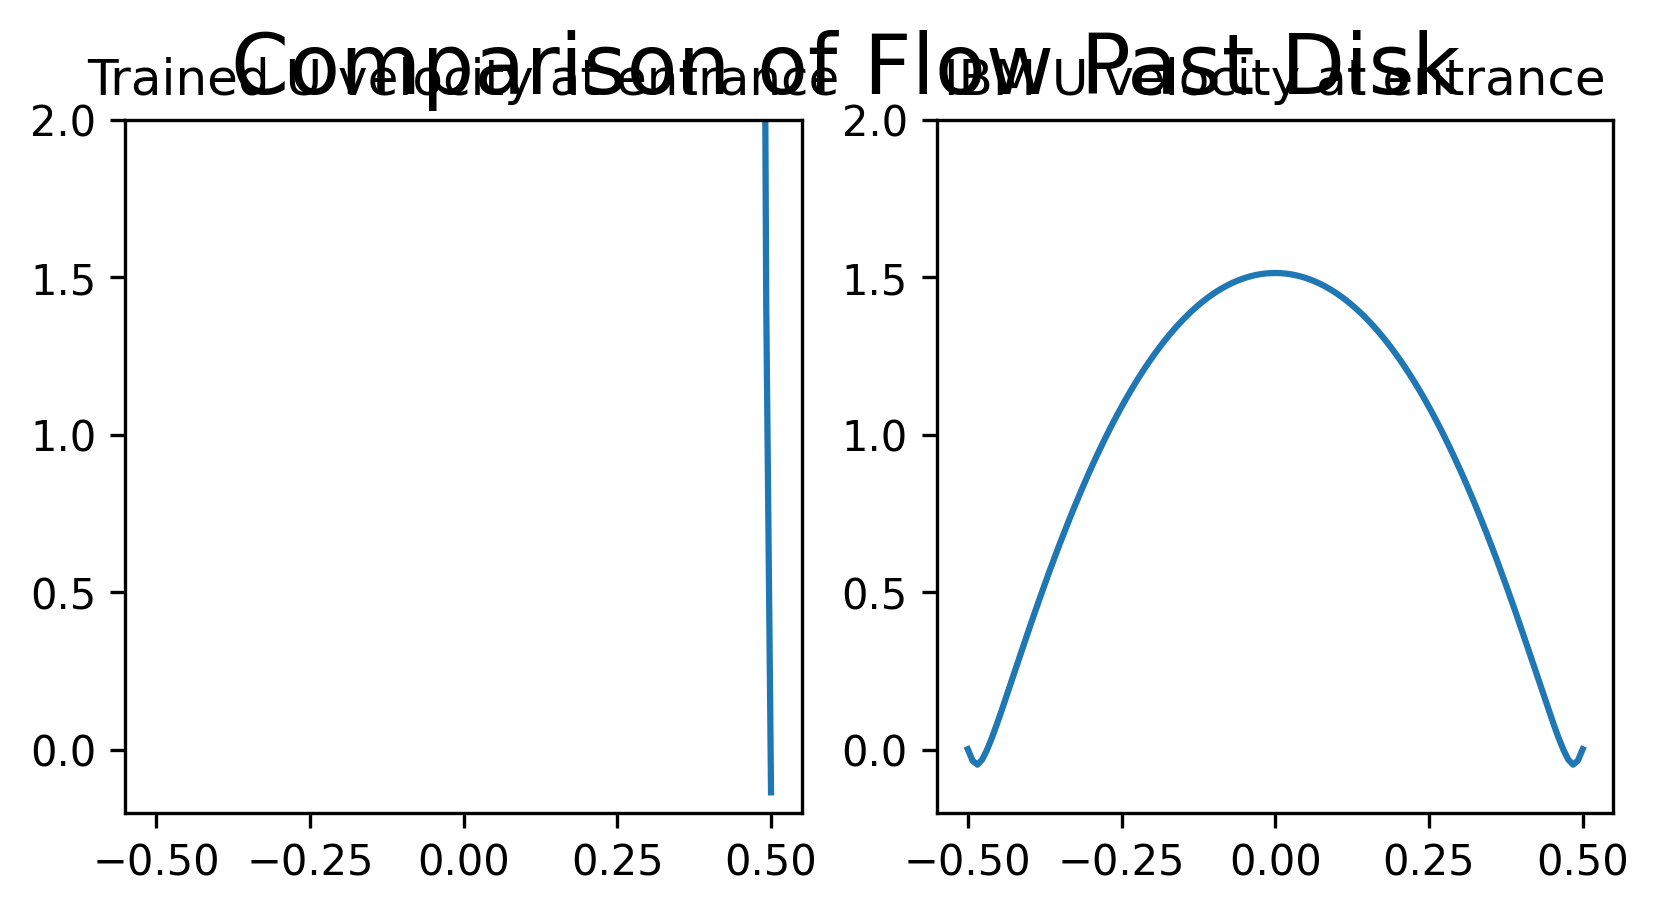

In [6]:
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.4, 3))

wall = np.linspace(-L_height, L_height, numpts_y)

fig.suptitle('Comparison of Flow Past Disk', fontsize=20)

ax[0].plot(wall, Trained_Vel_U[0,:])
ax[0].set_ylim(-0.2, 2)
ax[0].set_title('Trained U velocity at entrance')

ax[1].plot(wall, IBM_U[0,:])
ax[1].set_ylim(-0.2, 2)
ax[1].set_title('IBM U velocity at entrance')

print('Max entrance velocity of Trained = {:.4f}'.format(np.max(Trained_Vel_U[0,:])))
print('Max entrance velocity of IBM = {:.4f}'.format(np.max(IBM_U[0,:])))

### Plot Full

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

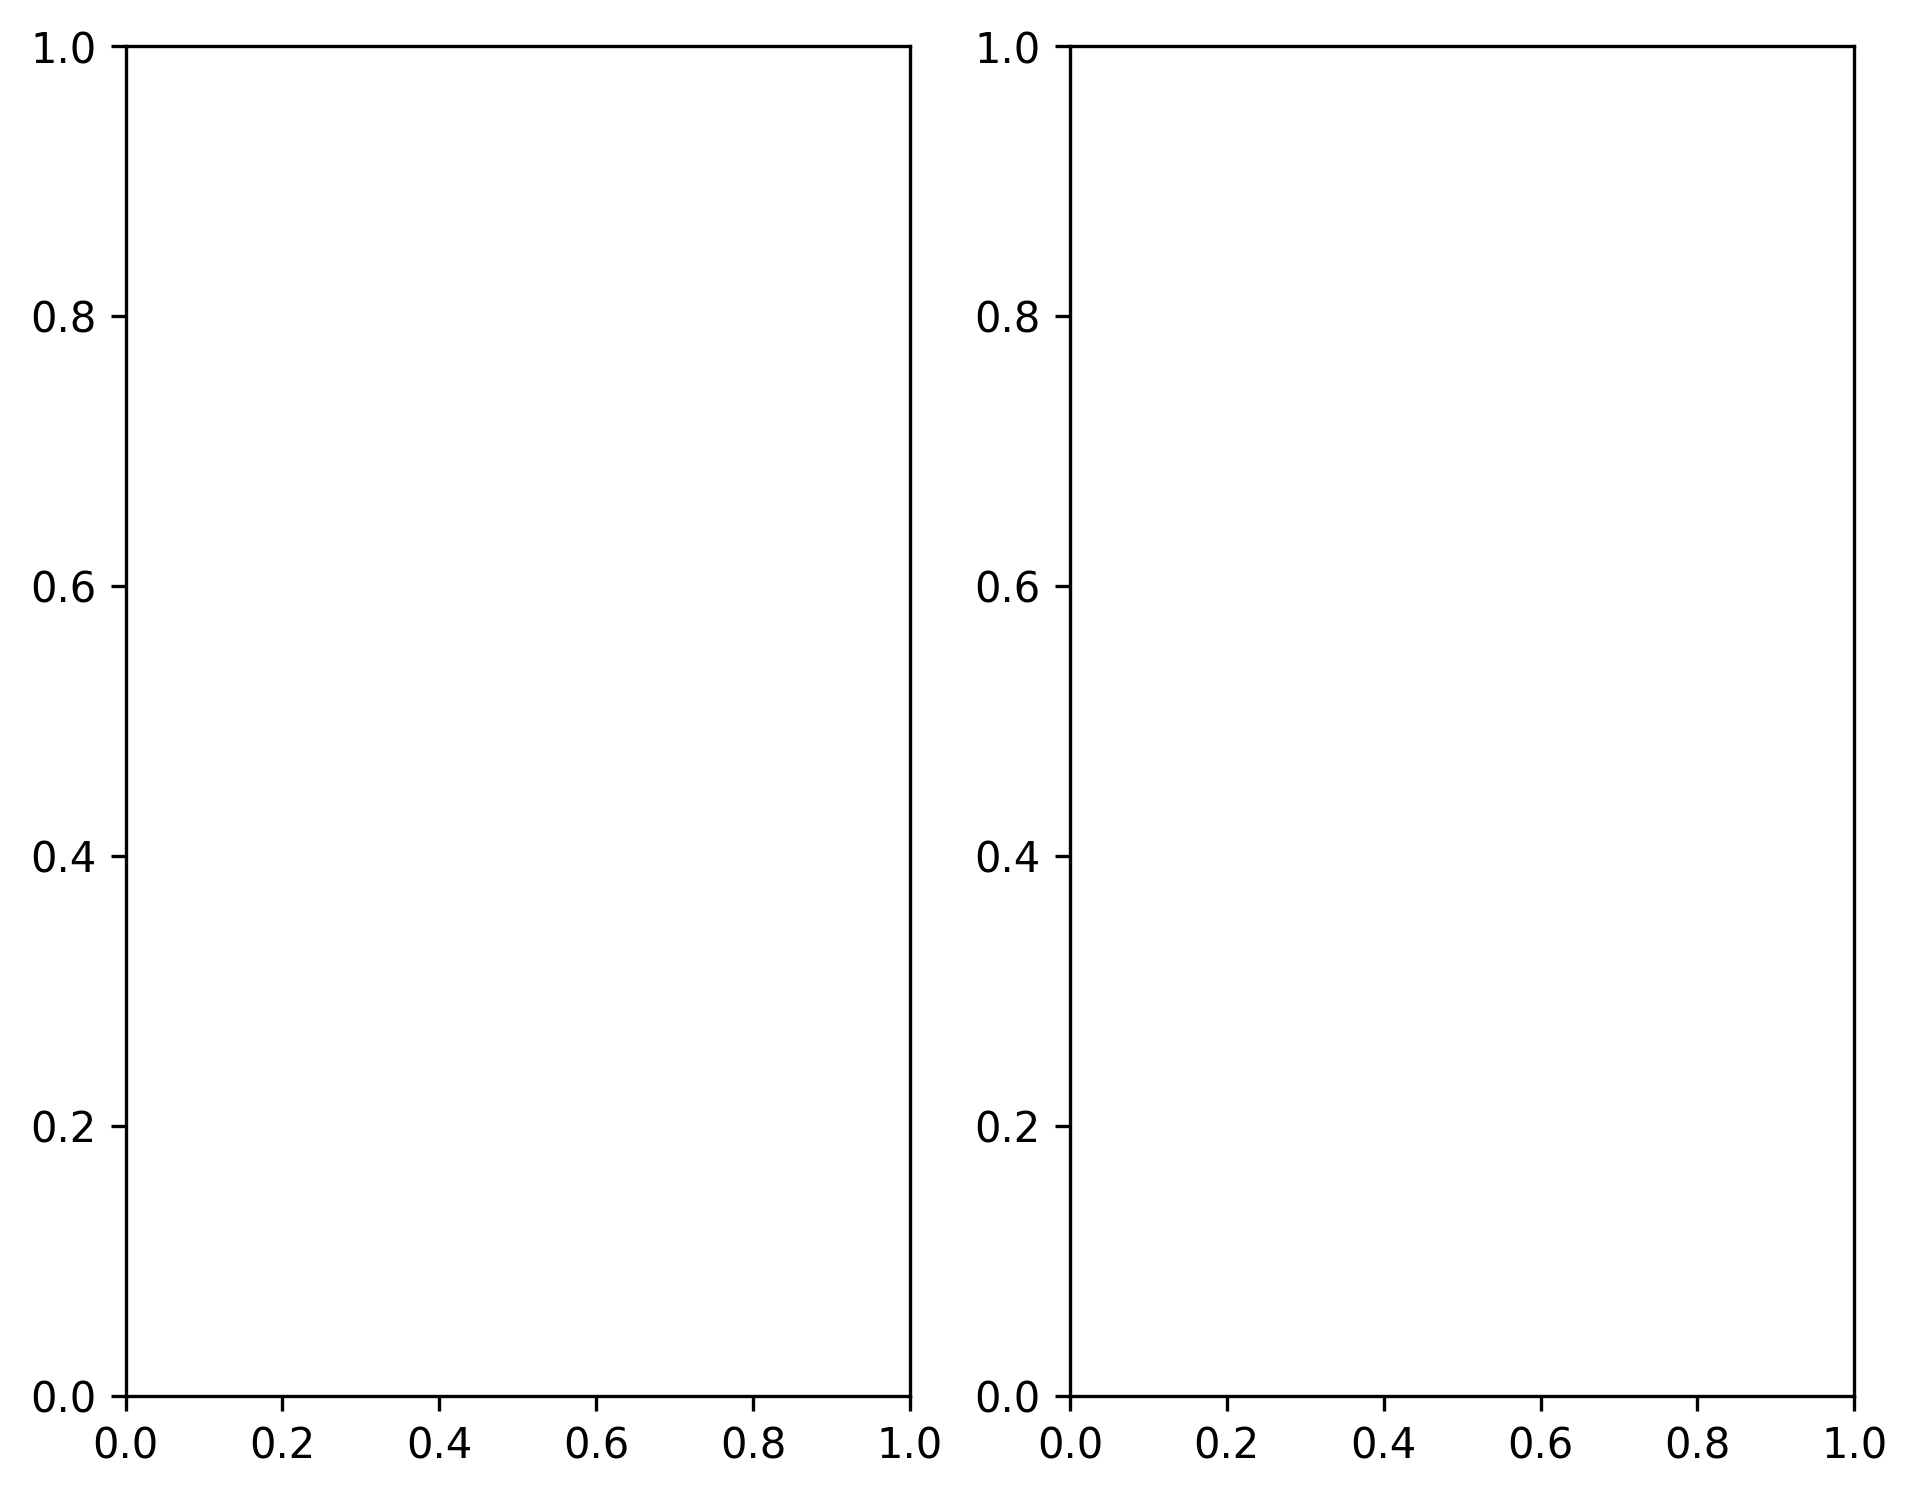

In [7]:
### Plotting
 
levels_flow_1 = np.linspace(-0.5, 75, 100)
levels_tick_1 = [0,1,2]

levels_flow_2 = np.linspace(-25, 25, 100)
levels_tick_2 = [-1, 0, 1]

plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[6.4, 5.0])
plt.tight_layout(pad=0.75)

## Plot 0

contour0 = ax[0,0].contourf(x1plot, x2plot, Trained_Vel_U, levels_flow_1, cmap=plt.cm.viridis)
ax[0,0].set_title(r'$\tilde{u}_1$ velocity')

ax[0,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar0_param = fig.add_axes(
    [ax[0,0].get_position().x1 + 0.01,
     ax[0,0].get_position().y0,
     0.01,
     ax[0,0].get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=levels_tick_1, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)

## Plot 3

contour3 = ax[0,1].contourf(x1plot, x2plot, Trained_Vel_V, levels_flow_2, cmap=plt.cm.viridis)
ax[0,1].set_title(r'$\tilde{u}_2$ velocity')

ax[0,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar3_param = fig.add_axes(
    [ax[0,1].get_position().x1 + 0.01,
     ax[0,1].get_position().y0,
     0.01,
     ax[0,1].get_position().height])
colorbar3 = plt.colorbar(contour3, ticks=levels_tick_2, cax = colorbar3_param)
colorbar3.ax.tick_params(labelsize=10)


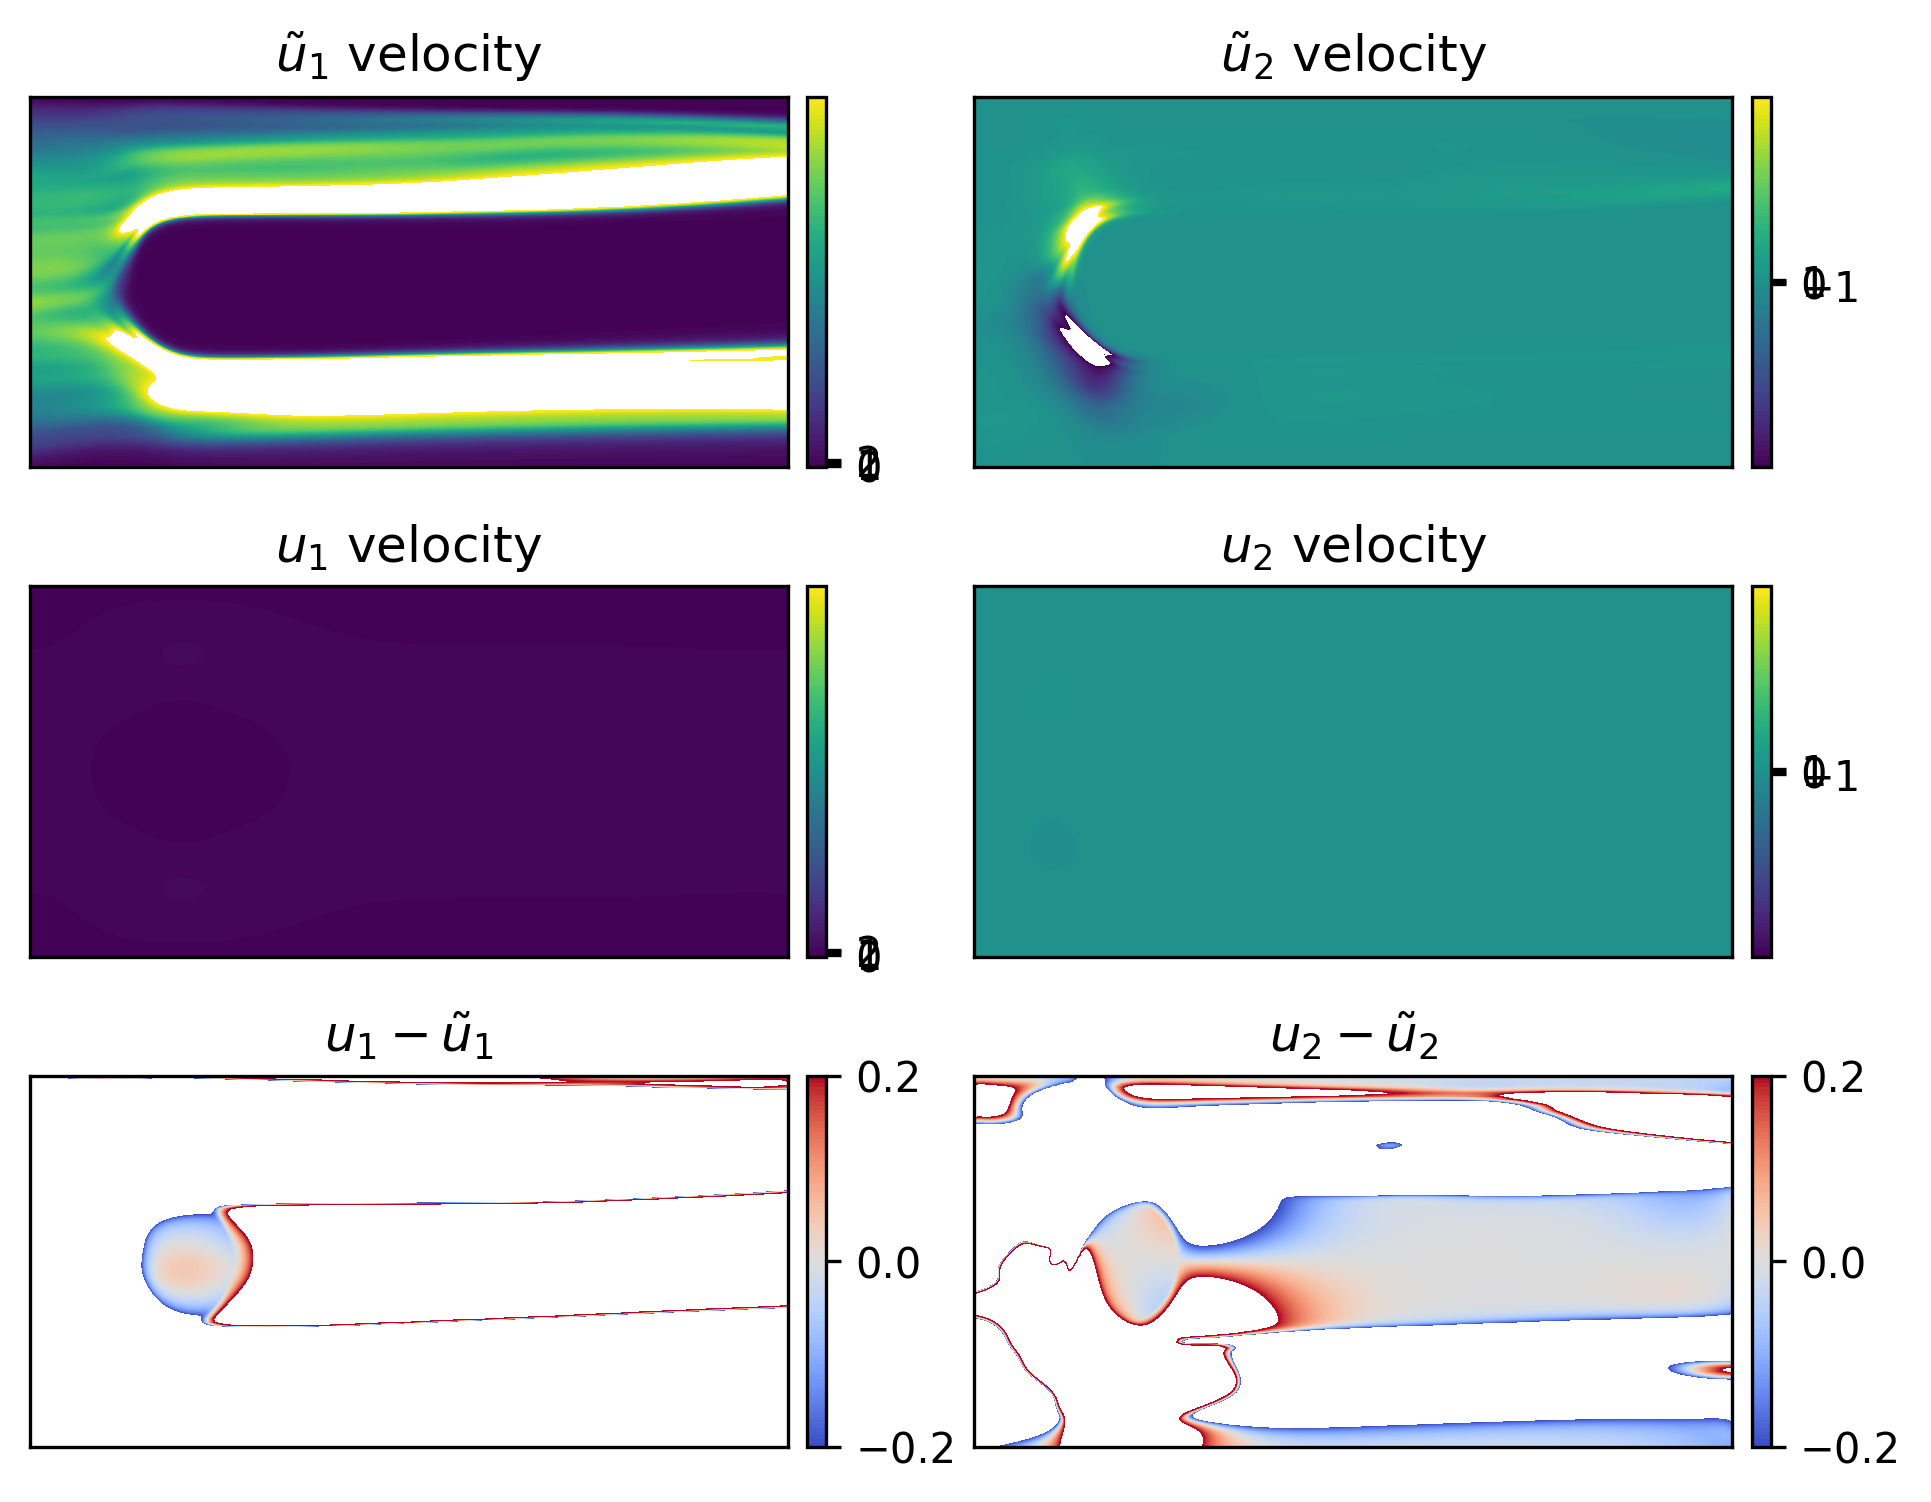

In [8]:
### Plotting
 
levels_flow_1 = np.linspace(-0.5, 125, 100)
levels_tick_1 = [0,1,2]

levels_flow_2 = np.linspace(-75, 75, 100)
levels_tick_2 = [-1, 0, 1]

error_levels = np.linspace(-0.2, 0.2, 100)
error_tick = np.linspace(-0.2, 0.2 ,3)

plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=[6.4, 5.0])
plt.tight_layout(pad=0.75)

## Plot 0

contour0 = ax[0,0].contourf(x1plot, x2plot, Trained_Vel_U, levels_flow_1, cmap=plt.cm.viridis)
ax[0,0].set_title(r'$\tilde{u}_1$ velocity')

ax[0,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar0_param = fig.add_axes(
    [ax[0,0].get_position().x1 + 0.01,
     ax[0,0].get_position().y0,
     0.01,
     ax[0,0].get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=levels_tick_1, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)

## Plot 1

contour1 = ax[1,0].contourf(x1plot, x2plot, IBM_U, levels_flow_1, cmap=plt.cm.viridis)
ax[1,0].set_title(r'$u_1$ velocity')

ax[1,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar1_param = fig.add_axes(
    [ax[1,0].get_position().x1 + 0.01,
     ax[1,0].get_position().y0,
     0.01,
     ax[1,0].get_position().height])
colorbar1 = plt.colorbar(contour1, ticks=levels_tick_1, cax = colorbar1_param)
colorbar1.ax.tick_params(labelsize=10)

## Plot 2

contour2 = ax[2,0].contourf(x1plot, x2plot, IBM_U - Trained_Vel_U, levels=error_levels, cmap=plt.cm.coolwarm)
ax[2,0].set_title(r'$u_1 - \tilde{u}_1$')

ax[2,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar2_param = fig.add_axes(
    [ax[2,0].get_position().x1 + 0.01,
     ax[2,0].get_position().y0,
     0.01,
     ax[2,0].get_position().height])
colorbar2 = plt.colorbar(contour2, ticks=error_tick, cax = colorbar2_param)
colorbar2.ax.tick_params(labelsize=10)

## Plot 3

contour3 = ax[0,1].contourf(x1plot, x2plot, Trained_Vel_V, levels_flow_2, cmap=plt.cm.viridis)
ax[0,1].set_title(r'$\tilde{u}_2$ velocity')

ax[0,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar3_param = fig.add_axes(
    [ax[0,1].get_position().x1 + 0.01,
     ax[0,1].get_position().y0,
     0.01,
     ax[0,1].get_position().height])
colorbar3 = plt.colorbar(contour3, ticks=levels_tick_2, cax = colorbar3_param)
colorbar3.ax.tick_params(labelsize=10)

## Plot 4

contour4 = ax[1,1].contourf(x1plot, x2plot, IBM_V, levels_flow_2, cmap=plt.cm.viridis)
ax[1,1].set_title(r'$u_2$ velocity')

ax[1,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar4_param = fig.add_axes(
    [ax[1,1].get_position().x1 + 0.01,
     ax[1,1].get_position().y0,
     0.01,
     ax[1,1].get_position().height])
colorbar4 = plt.colorbar(contour4, ticks=levels_tick_2, cax = colorbar4_param)
colorbar4.ax.tick_params(labelsize=10)

## Plot 5

contour5 = ax[2,1].contourf(x1plot, x2plot, IBM_V - Trained_Vel_V, levels=error_levels, cmap=plt.cm.coolwarm)
ax[2,1].set_title(r'$u_2 - \tilde{u}_2$')

ax[2,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar5_param = fig.add_axes(
    [ax[2,1].get_position().x1 + 0.01,
     ax[2,1].get_position().y0,
     0.01,
     ax[2,1].get_position().height])
colorbar5 = plt.colorbar(contour5, ticks=error_tick, cax = colorbar5_param)
colorbar5.ax.tick_params(labelsize=10)



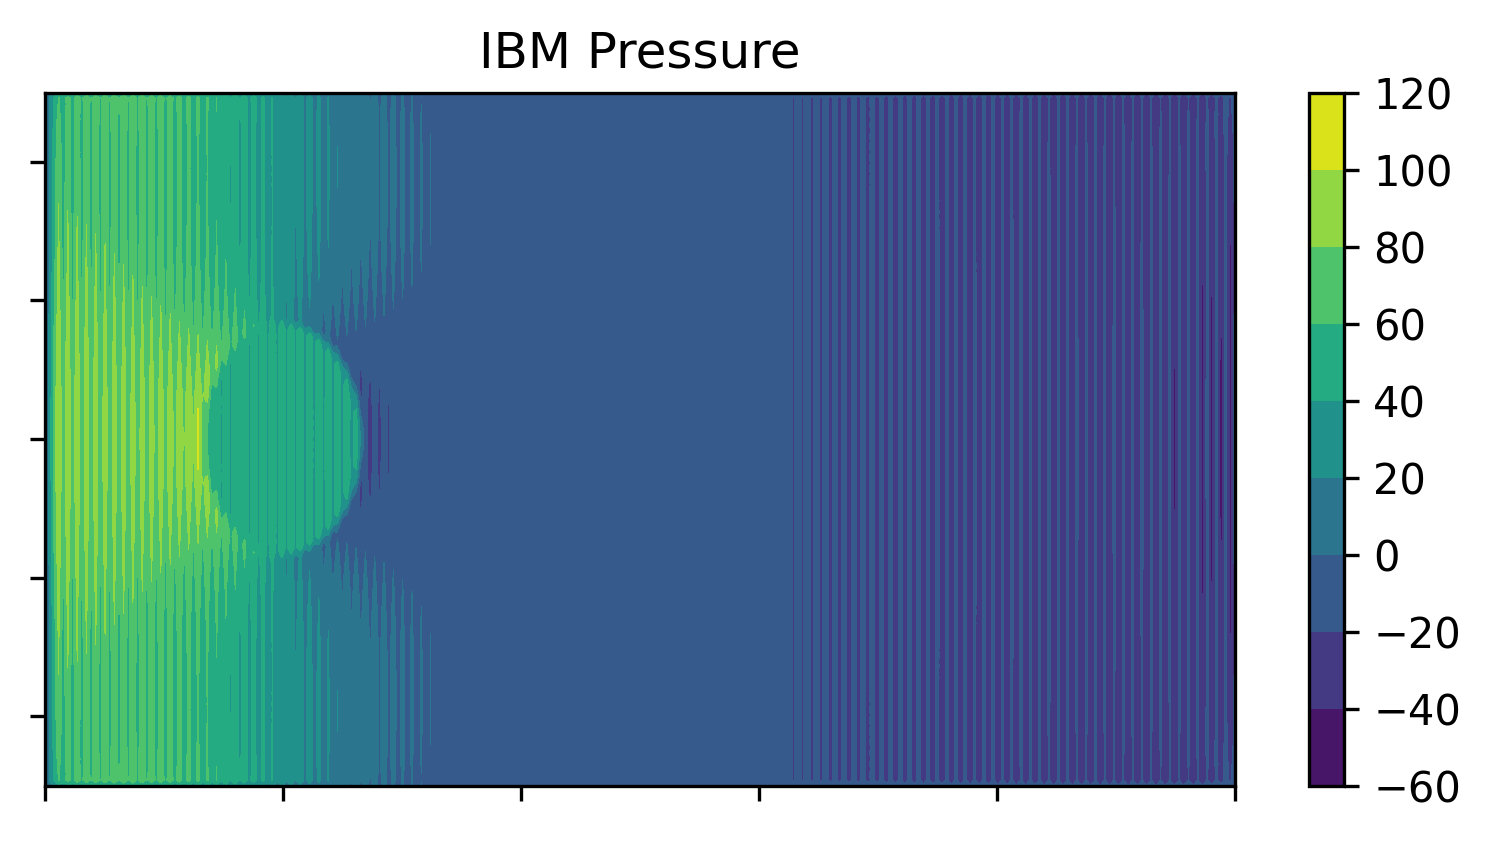

In [ ]:
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 3.0])

#contour0 = ax[0].contourf(x1plot, x2plot, Trained_Pressure, cmap=plt.cm.viridis)
#ax[0].set_title(r'Trained Pressure')
#ax[0].set_xticklabels([])
#ax[0].set_yticklabels([])
#plt.colorbar(contour0, ax=ax[0])

contour1 = ax.contourf(x1plot, x2plot, IBM_P, cmap=plt.cm.viridis)
ax.set_title(r'IBM Pressure')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar(contour1, ax=ax)

#contour2 = ax[2].contourf(x1plot, x2plot, IBM_P - Trained_Pressure, cmap=plt.cm.coolwarm)
#ax[2].set_title(r'Difference between IBM and Trained Pressure')
#ax[2].set_xticklabels([])
#ax[2].set_yticklabels([])
#plt.colorbar(contour2, ax=ax[2])

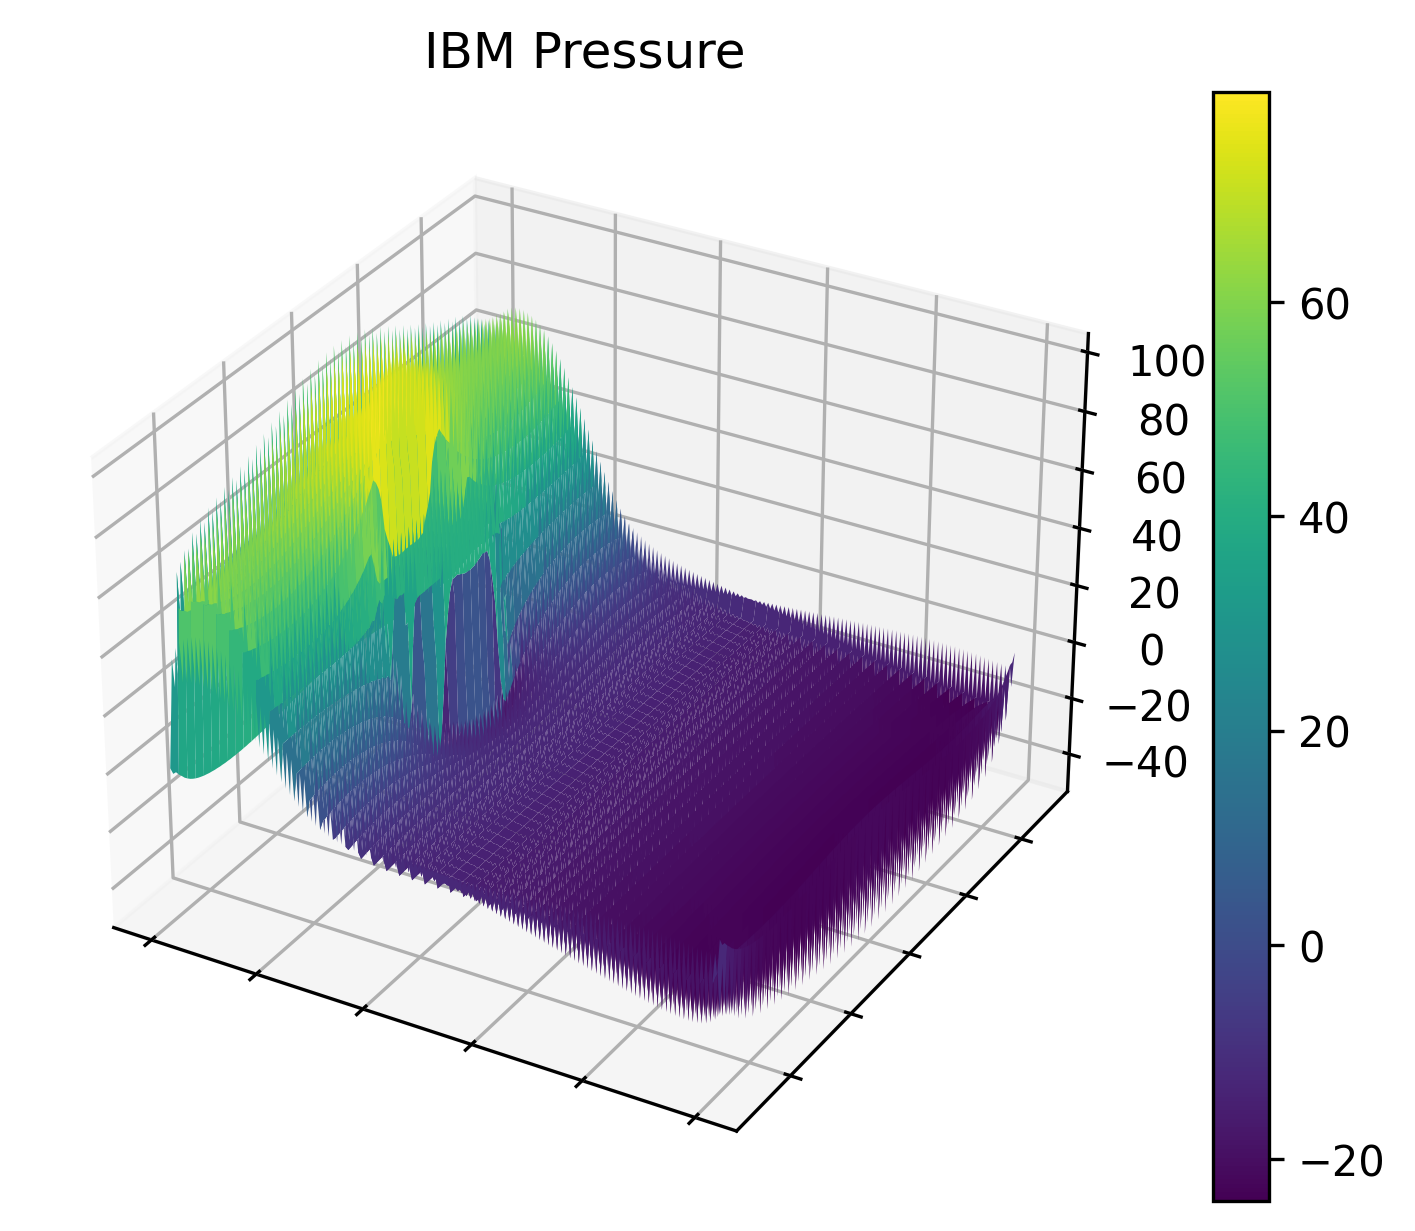

In [ ]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

contour1 = ax.plot_surface(x1plot, x2plot, IBM_P, cmap=plt.cm.viridis)
ax.set_title(r'IBM Pressure')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar(contour1, ax=ax)